# Handwritten Digit Recognition Using Pytorch 

En este notebook discutiremos el uso de redes neuronales para desarrollar un clasificador que reconozca digitos hechos a mano. Desarrollaremos de cero un clasificador usando pytorch y el conjuto de datos de MNIST. 

# Dataset

Usaremos la popular base de datos de MNIST. Este conjunto de datos consiste de una colleción de $70,000$ digitos escritos a mano. Pytorch nos ofrece los datos ya preparados y divididos, un $90\%$ para entrenamiento y el resto para pruba. Esto representa una ventaja pues sólo es necesario escribir unas cuantas lineas de código como se verá después.

Usaremos las siguientes bibliotecas:

In [1]:
import numpy as np
import torch # biblioteca similar a python para manipular tensores
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision.datasets import MNIST
from torchvision import transforms # módulo con transformaciones de tensores
from torch import nn, optim # son los modulos de las arquitecturas de redes y los optimizadores, respectivamente
import torch.nn.functional as F # módulo para funciones usadas en las redes
from torchsummary import summary # muestra la información de un modelo
from tqdm import tqdm # nos permite generar barras de progeso para el entrenamiento

Definimos la siguiente pipeline de transformaciones para poder alimentar al modelo con los datos en la forma que requiere. Usareamos el módulo ``transforms``.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,),(0.5,)),
])

* ``ToTensor()``: Convierte la imagen en arreglos numéricos que entiende la computadora. Separa a cada pixel de la imagen en los canales rojo, verde y azul y le da un valor numérico de acuerdo al brillo que va de 0 a 255. El producto es un tensor que representa a la imagen en ``torch``.

* ``Normalize()``: normaliza a las entradas de un tensor con los parametros de media y desviación estandar. 

Ahora descargaremos la base de datos. 

In [3]:
trainset = MNIST('PATH_TO_STORE_TRAINSET', 
                         download=True, train=True, transform=transform)

testset = MNIST('PATH_TO_STORE_TRAINSET', 
                         download=True, train=False, transform=transform)

In [4]:
len(testset)

10000

Ahora será ncesario separar una parte del conjunto de entrenamiento para usarlo en la validación:

In [5]:
valid_size = 0.2 # parte para validar
n = len(trainset)
indices = list(range(n))
np.random.shuffle(indices) # revolvemos los indices
split = int(np.floor(valid_size * n)) 
train_idx, valid_idx = indices[split:], indices[:split] # seprarmos los indices

train_set = torch.utils.data.Subset(trainset, train_idx) # tomamos un subconjunto de acuerdo a los indices
val_set = torch.utils.data.Subset(trainset, valid_idx)
n_train = len(train_set)
n_val = len(val_set) 

Ya con los conjuntos de datos almacenados y separados para el entrenamiento, validación y prueba, será necesario darles la estructura de un objeto de la clase ``DataLoader``, que permite separar la conjuto de datos por batches y permite crear iteradores simples o multi-proceso sobre el conjunto de datos.

In [6]:
train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=32, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(testset,
                                          batch_size=1, shuffle=False)

In [7]:
len(test_loader)

10000

## Exploración y análisis del Dataset

En esta sección haremos una exploración y análisis de las imagenes de nuestro conjunto de datos. En la siguiente instrucción desempaquetamos las etiquetas y las imagenes del conjunto de entrenamiento.

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

Ahora veamos las dimensiones de las imagenes y las etiquetas. La primera dimensión indica el batch size, cada elemento del bach es una imagen de $28 \times 28$.

In [9]:
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


La siguiente instrucción solo es ilustrativa y muestra como es una imagen del conjunto con su etiqueta.

dígito:  7


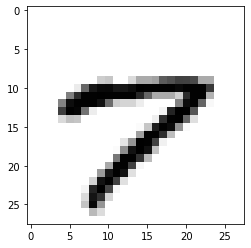

In [10]:
index = 10
plt.imshow(images[index].numpy().squeeze(), cmap='gray_r'); 
print('dígito: ',int(labels[index]))

## Arquitectura de la red

Ahora procedemos a la definición del modelo. Proponemos una red feedforward con 2 capas intermedias, con función de activación relu. Como la tarea es de clasificar la capa de salida consitira de 10 nodos, una por cada clase. 

Definiremos una clase llamada ``Classifier``, esta clase hereda de ``nn.Module`` que es una clase abstracta que modela a las redes neuronales, usaremos esta estructura para definir una red neuronal con dos capas intermedias de tamaño $128$ y $64$ respectivamente. Después de definir la estructura de las capas de salida e intermedias como atributos, les damos un orden en el método ``forward`` donde las conectamos y les aplicamos la función de activación, finalmente agragamos la capa de salida. Note que la capa de salida no tiene la función de activación usual, más adelante veremos porque.

In [11]:
input_size = 28 * 28
hidden_sizes = [128, 64]

class Classifier(nn.Module):
    
    def __init__(self, input_size=input_size, hidden_sizes=hidden_sizes , classes=10):
        super(Classifier, self).__init__()
        s1, s2 = hidden_sizes
        self.linear1 = nn.Linear(input_size, s1) # capa intermedia 1
        self.linear2 = nn.Linear(s1, s2) # capa intermedia 2
        self.linear3 = nn.Linear(s2, classes)  # capa de salida

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

Declaramos al modelo.

In [12]:
model = Classifier()

Llamamos a la función ``summary`` para ver información acerca del modelo, en la seunda entrada deben de ponerse la dimensión de los atributos.

In [13]:
summary(model, (1, 28 * 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
            Linear-2                [-1, 1, 64]           8,256
            Linear-3                [-1, 1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [14]:
print(model)

Classifier(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


## Optimizador y función de costos

Discutiremos más adelante la capa de salida de la arquitectura y la función costos (*CIFAR10_pytorch.ipynb*). Sólo es necesario notar que no es necesario usar la función softmax pues ya viene integrada en la función de costos. Tampoco es necesario que las etiquetas tengan la estructura *one hot*, pues la función *CrossEntropyLoss* nos evita esa tarea.

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

El optimizador es proporcionado por ``torch.optim``, es el que realizará la tarea de descenso de gradiente y actualizará los pesos por medio del métdodo de *backpropagation*. 

## Entrenamiento

Ya estamos preparados para continuar con el entrenamiento para ello definiremos la función ``training_loop``. En la siguiente función la red neuronal itererá sobre conjunto de entrenamiento y lo integrará con el optimizador que hará su tarea. Note que a diferencia de Keras es necesario decirle a la red neuronal cuando va a tener que darle seguiemiento al gradiente en cada paso para después hacer backpropagation.

No sólo usaremos esta función para el entrenamiento si no que también para la validación. Es necesario decirle a la red cuando vamos a hacer el proceso de validación y no darle seguimiento del grandiente para eso sirve la bandera ``valid``.

In [16]:
def training_loop(train_loader, model, optimizer, loss_function, pbar, valid=False):
    running_loss = 0.0
    correct = 0
    total = 0
    if valid: 
        model.eval() # modo de validación del modelo 
    for i, data in enumerate(train_loader, 0):
        X, Y = data
        X = X.view(images.shape[0], -1) # transformamos los datos para la red
        # print(X.shape)
        if not valid:
            optimizer.zero_grad() # reinicia el gradiente
            
        pred = model(X)
        #import pdb; pdb.set_trace()
        loss = loss_function(pred, Y)
        if not valid:
            loss.backward() # cálcula las derivadas 
            optimizer.step() # paso de optimización 
            
        running_loss += loss.item()
        
        avg_loss = running_loss/(i + 1)
        
        probs = F.softmax(pred, 1)
        label = torch.argmax(probs, dim=1)
        correct += torch.sum(label == Y).item()
        total += Y.shape[0]
        acc = correct/total
        
        pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
        pbar.update(Y.shape[0])
        
    return avg_loss, acc

Ahora establecemos la cantidad de épocas y generamos las listas donde guardaremos el rendimiento del modelo.

In [17]:
import time
EPOCHS = 15

train_time = 0
epoch_loss = []
epoch_acc = []
val_loss = []
val_acc = []

In [20]:
dataiter = iter(train_loader)
len(train_loader) * 32

48000

Juntamos todo y empezamos el entrenamiento.

In [19]:

for epoch in range(EPOCHS):
    start_time = time.time()
    with tqdm(total = n_train, position=0) as pbar_train:
        pbar_train.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - training')
        pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
        loss_train, acc_train = training_loop(train_loader, model, optimizer, criterion, pbar_train, valid=False)
        train_time +=  time.time() - start_time
    with tqdm(total = n_val, position=0) as pbar_val:
        pbar_val.set_description(f'Epoch {epoch +1}/'+str(EPOCHS)+' - validation')
        pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
        loss_val, acc_val = training_loop(val_loader, model, None, criterion, pbar_val, valid=True)
    
    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)
    val_loss.append(loss_val)
    val_acc.append(acc_val)

print("--- %s minutes ---", train_time)

Epoch 3/15 - training:  52%|█████▏    | 24992/48000 [00:07<00:07, 3166.55it/s, acc=0.9526, avg_loss=0.1532]


KeyboardInterrupt: 

## Rendimiento del modelo

In [ ]:
plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prueba del modelo

In [ ]:
running_loss = 0.0
correct = 0
total = 0
for i, data in enumerate(test_loader, 0):
    X, Y = data
    X = X.view(-1, 28 * 28) # transformamos los datos para la red        
    pred = model(X)
    loss = criterion(pred, Y)
    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct += torch.sum(label == Y).item()
    total += Y.shape[0]
    acc = correct/total
        
print('accuracy: {}, loss: {}'.format(acc, avg_loss))